In [ ]:
!pip3 install tf-explain

2022-08-03 21:39:46.535840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 21:39:46.607182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:46.717042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:46.717869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14512483682821294295
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11135350895875225883
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Num GPUs Available:  1


2022-08-03 21:39:49.004524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:49.005472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:49.006146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:49.006874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 21:39:49.007588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 40, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 40, 256)       2

2022-08-03 21:39:53.082164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


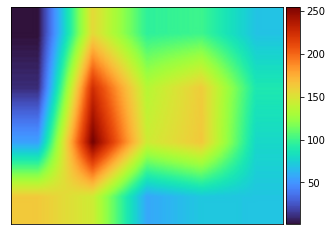

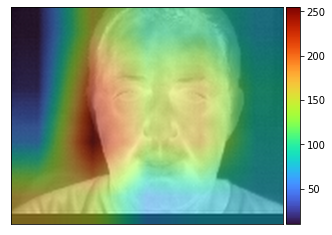


37_vassilisA_2_f_M_54_90


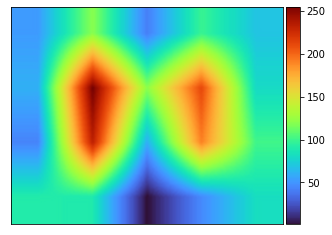

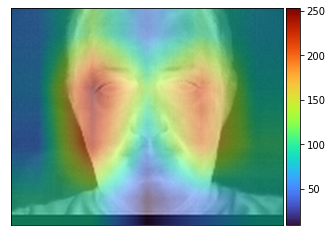


37_vassilisA_3_f_M_54_90


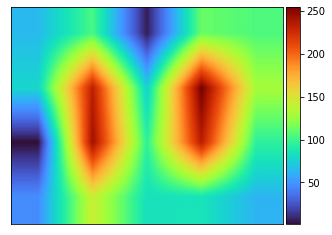

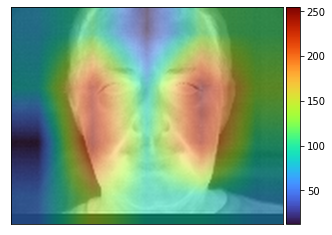


37_vassilisA_4_f_M_54_90


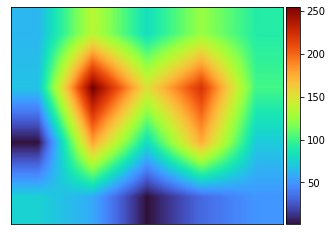

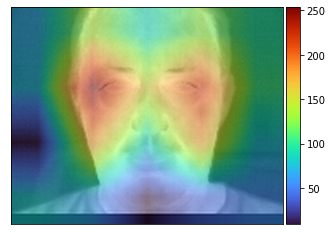


38_christos_1_f_M_33_76


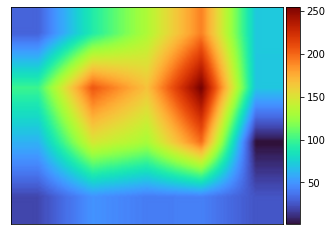

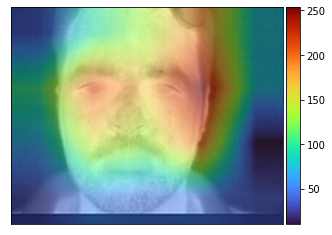


38_christos_2_f_M_33_76


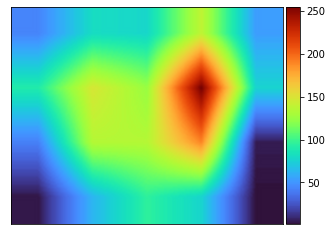

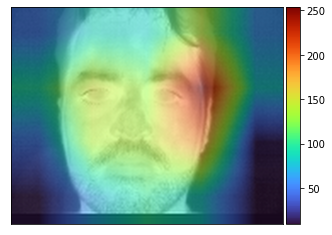


38_christos_3_f_M_33_76


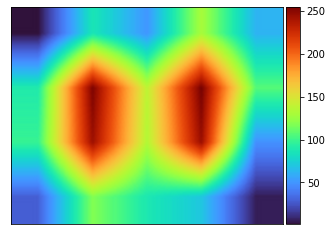

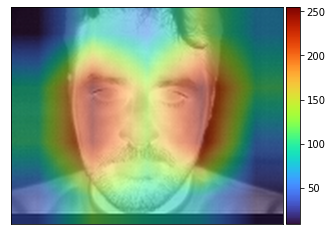


38_christos_4_f_M_33_76


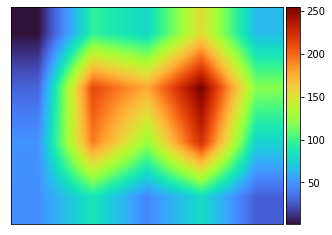

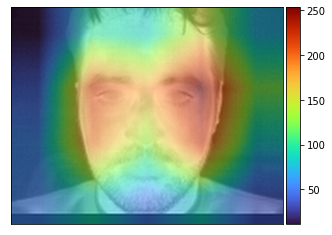


39_anna_1_f_F_46_59


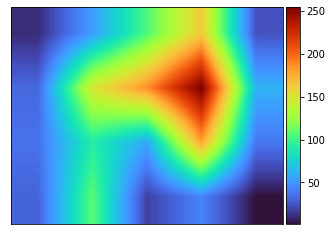

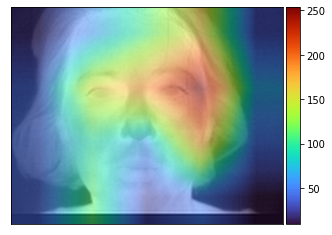


39_anna_2_f_F_46_59


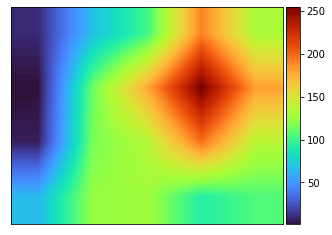

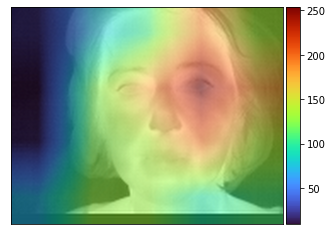


39_anna_3_f_F_46_59


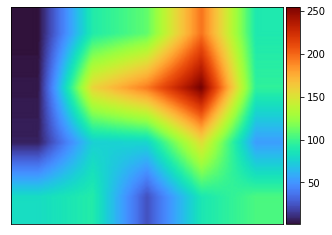

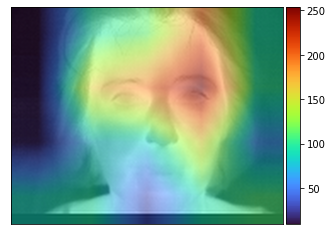


39_anna_4_f_F_46_59


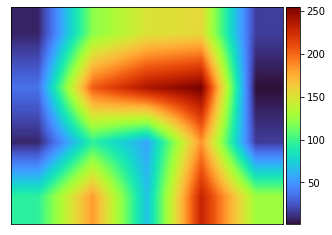

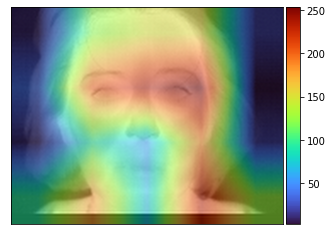


40_spiliop_1_f_M_43_74


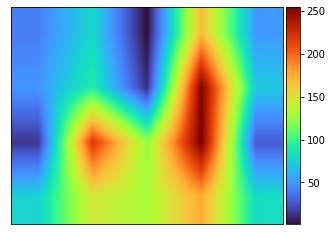

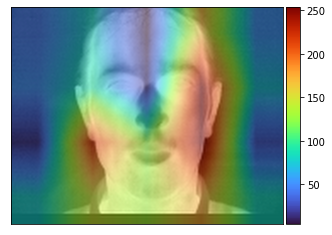


40_spiliop_2_f_M_43_74


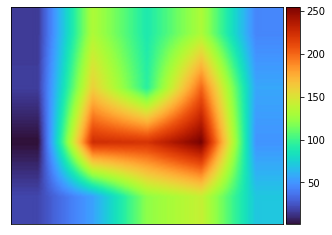

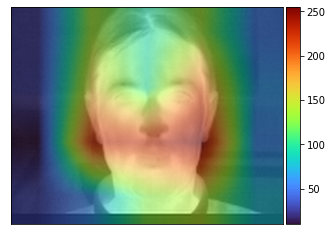


40_spiliop_3_f_M_43_74


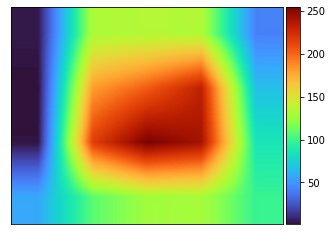

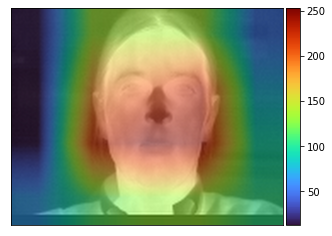


40_spiliop_4_f_M_43_74


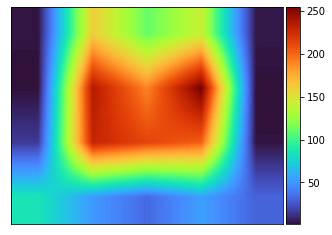

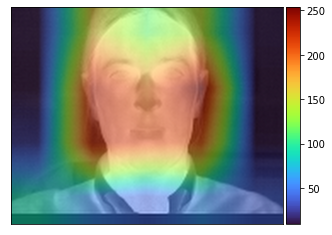


41_kalp_1_f_M_62_95


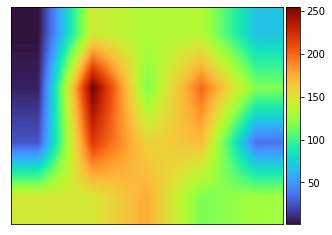

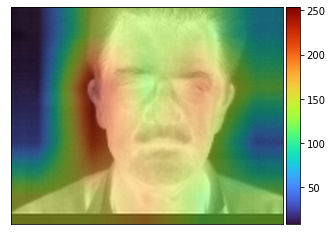


41_kalp_2_f_M_62_95


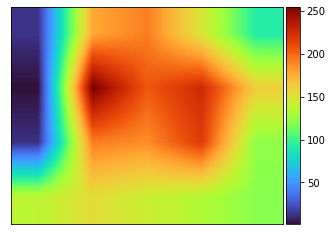

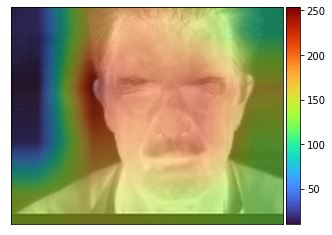


41_kalp_3_f_M_62_95


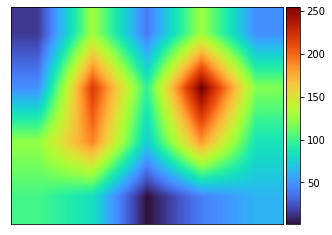

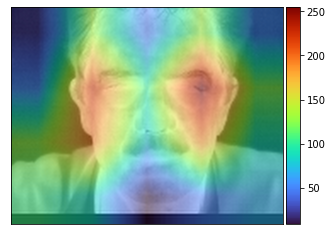


41_kalp_4_f_M_62_95


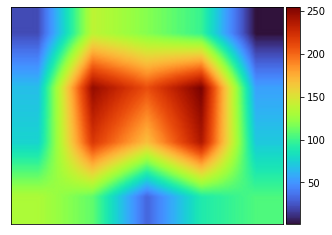

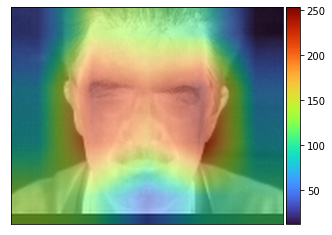

In [2]:
# Defining random seeds to enable reproducibility
from numpy.random import seed
seed(1)

import tensorflow as tf
tf.random.set_seed(1)

import random
random.seed(1)

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
from tf_explain.core.grad_cam import GradCAM


print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


def load_patras_dataset():
    """
    Loads the datasets encoded in .pkl files and returns its decoded form.

    Returns
    -------
    list
        A list of n-dimensional arrays representing the subjects samples that will be used to \\
        test the drunkenness classification model.
    ndarray
        A n-dimensional array representing the test set labels.
    """

    print("Loading Sober-Drunk Face Dataset, from Patras University")
    
    # Defining the sample and label sets filenames
    sets = [
        "Insert the unbalanced x_test-set.pkl file path here",
        "Insert the unbalanced y_test-set.pkl file path here"
    ]
    
    # Defining an empty list for storing the decoded datasets
    loaded_datasets = []
 
    # Iterating over the dataset files
    for set_ in sets:
        # Opening the .pkl file in read mode
        with open(set_, 'rb') as file:
            # Appending the decoded dataset to the datasets list
            loaded_datasets.append(pickle.load(file))
    
    # Unpacking the datasets list into individual subsets
    x_test, y_test = loaded_datasets

    # Converting the label list to the n-dimensional array format
    y_test = np.array(y_test)
    
    # Printing the dataset length
    print("\nTest set samples: {0}".format(len(x_test)))
    
    # Returning the test set samples and its respective labels
    return x_test, y_test


def min_max_norm(dataset):
    """
    Normalizes the keyframes according to the minimum-maximum norm, \\
    such that pixel values ranges from 0 to 1.

    Parameters
    ----------
    dataset : list
        A list of n-dimensional arrays representing the subjects keyframes.

    Returns
    -------
    ndarray
        A n-dimensional array representing keyframes with pixel values ranging from 0 to 1.
    """

    # Converting the dataset type from list to n-dimensional array
    dataset = np.asarray(dataset, dtype="int16")

    # Finding the keyframes minimum and maximum values
    x_min = dataset.min(axis=(1, 2), keepdims=True)
    x_max = dataset.max(axis=(1, 2), keepdims=True)

    # Applying the minimum-maximum norm to each keyframe
    norm_dataset = (dataset - x_min) / (x_max - x_min)

    # Printing the minimum and maximum values from a given sample for sanity check
    print("\nMinMax normalization")
    print("dataset shape: ", norm_dataset.shape)
    print("min: ", norm_dataset[0].min())
    print("max: ", norm_dataset[0].max())

    # Returning the normalized dataset
    return norm_dataset


def visualize_gradcam(cam, filename):
    """
    Displays the class activation mapping for a given test set sample.

    Parameters
    ----------
    cam : ndarray
        A n-dimensional array representing the class activation map.
    filename : str
        A string indicating the filename to save the plot.
    """

    # Creating a new figure
    plt.figure()

    # Getting the figure current axis
    ax = plt.gca()
    
    # Displaying the class activation mapping
    im = ax.imshow(cam, cmap='turbo', interpolation='lanczos')
    
    # Hidding the axis ticks
    plt.xticks([])
    plt.yticks([])
    
    # Defining a colorbar to interpret the class activations relevance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    # Saving the given sample class activation mapping
    plt.savefig("{0}_grad-cam_blending.pdf".format(filename), dpi=600, bbox_inches='tight', pad_inches=0.001)
    
    # Showing the given sample class activation mapping
    plt.show()


def gradcam():
    """
    Performs the Gradient-weighted Class Activation Mapping visualization technique.
    """

    # Defining the layer whose gradients will be used to highlight the predicted class 
    # discriminating features
    LAYER_NAME = 'block5_pool'
    
    # Loading the final drunkenness classification model
    model = load_model('sober-drunk_final-model_ft_fold-3.h5')

    # Printing the final model summary
    model.summary()
    
    # Loading the test set samples
    x_test = load_patras_dataset()[0]

    # Applying the min-max normalization
    x_test = min_max_norm(x_test)
    
    # Defining the filenames of each test set sample
    subjects = ['37_vassilisA_1_f_M_54_90',
                '37_vassilisA_2_f_M_54_90',
                '37_vassilisA_3_f_M_54_90',
                '37_vassilisA_4_f_M_54_90',
                '38_christos_1_f_M_33_76',
                '38_christos_2_f_M_33_76',
                '38_christos_3_f_M_33_76',
                '38_christos_4_f_M_33_76',
                '39_anna_1_f_F_46_59',
                '39_anna_2_f_F_46_59',
                '39_anna_3_f_F_46_59',
                '39_anna_4_f_F_46_59',
                '40_spiliop_1_f_M_43_74',
                '40_spiliop_2_f_M_43_74',
                '40_spiliop_3_f_M_43_74',
                '40_spiliop_4_f_M_43_74',
                '41_kalp_1_f_M_62_95',
                '41_kalp_2_f_M_62_95',
                '41_kalp_3_f_M_62_95',
                '41_kalp_4_f_M_62_95']
    
    # Iterating over the test set samples
    for i in range(len(x_test)):
        # Reshaping the input image format
        input_img = np.expand_dims(x_test[i], axis=0)        
        data = (input_img, None)
        
        print("\n{0}".format(subjects[i]))
        
        # Instantiating the Grad-CAM explainer object
        explainer = GradCAM()

        # Running the Grad-CAM explainer
        cam = explainer.explain(data, model, class_index=-1, layer_name=LAYER_NAME, colormap=cv2.COLORMAP_TURBO, image_weight=0.0)
        
        # Displaying the raw class activation map
        visualize_gradcam(cam, subjects[i])
        
        
        # Normalizing the input image
        input_img = x_test[i] 
        input_img = cv2.normalize(input_img,  np.zeros((128, 160)), 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Defining the transparency weights
        alpha = 0.5
        beta = 1 - alpha
        gamma = 0

        # Superimposing the class activation map over the input image
        overlayed_img = cv2.addWeighted(input_img, alpha, cam, beta, gamma)
        
        # Displaying the overlaid class activation mapping
        visualize_gradcam(overlayed_img, subjects[i])


# Revising the final model extracted features
gradcam()
